In [20]:
import os, re, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# ---------- 재현성 ----------
SEED = 42
np.random.seed(SEED)

# ---------- 공휴일 ----------
try:
    import holidays
    KR_HOLIDAYS = holidays.KR(years=[2023, 2024, 2025])
    def is_holiday(d): return d in KR_HOLIDAYS
except Exception:
    # 라이브러리 없으면 간단한 대체(주요 국경일 중심, 완전 정확하진 않음)
    BASIC_HOLI = {(m, d) for m, d in [(1,1),(3,1),(5,5),(6,6),(8,15),(10,3),(10,9),(12,25)]}
    def is_holiday(d): return (d.month, d.day) in BASIC_HOLI

# ---------- 평가 (0 제외 SMAPE) ----------
def smape_ignore_zero(y_true, y_pred):
    mask = (y_true != 0)
    if mask.sum() == 0:
        return 0.0
    yt = y_true[mask]
    yp = y_pred[mask]
    denom = (np.abs(yt) + np.abs(yp))
    denom[denom == 0] = 1e-9
    return np.mean(2.0 * np.abs(yt - yp) / denom)

def lgb_smape_eval(y_pred, dataset):
    y_true = dataset.get_label()
    return 'smape_no0', smape_ignore_zero(y_true, y_pred), False  # False = 낮을수록 좋음

# ---------- 문자열 분리 ----------
def split_store_menu(x):
    parts = str(x).split('_', 1)
    if len(parts) == 1: return parts[0], ''
    return parts[0], parts[1]

# ---------- 캘린더/시즌 피처 ----------
PEAK_MONTHS = {1,2,7,8,12}  # 필요시 조정
def add_calendar_features(df):
    df['date'] = pd.to_datetime(df['영업일자'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dow'] = df['date'].dt.weekday  # Mon=0
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    df['is_holiday'] = df['date'].dt.date.map(lambda d: int(is_holiday(d)))
    # 전/후 공휴일
    df['is_pre_holiday']  = df['date'].dt.date.map(lambda d: int(is_holiday(d + timedelta(days=1))))
    df['is_post_holiday'] = df['date'].dt.date.map(lambda d: int(is_holiday(d - timedelta(days=1))))
    # 성수기
    df['is_peak'] = df['month'].isin(PEAK_MONTHS).astype(int)
    # 주기성 특징
    df["month_sin"], df["month_cos"] = np.sin(2 * np.pi * df["month"] / 12.0), np.cos(2 * np.pi * df["month"] / 12.0)
    df["wday_sin"], df["wday_cos"] = np.sin(2 * np.pi * df["dow"] / 7.0), np.cos(2 * np.pi * df["dow"] / 7.0)
    return df

# ---------- 결측 날짜 0채우기 ----------
def ensure_daily_continuity(df):
    # 각 시계열(영업장명_메뉴명)별로 연속 일자 보장
    out = []
    for k, g in df.groupby('영업장명_메뉴명', sort=False):
        g = g.sort_values('영업일자').copy()
        full = pd.DataFrame({
            '영업일자': pd.date_range(g['영업일자'].min(), g['영업일자'].max(), freq='D')
        })
        full['영업장명_메뉴명'] = k
        full = full.merge(g, on=['영업일자','영업장명_메뉴명'], how='left')
        full['매출수량'] = full['매출수량'].fillna(0.0)
        out.append(full)
    return pd.concat(out, ignore_index=True)

# ---------- 시계열 라그/롤링 (수정본) ----------
def add_ts_features(df,
                    lags=(1,2,3,5,7,14,21,28),
                    roll_windows=(3,7,14,21,28,56)):
    df = df.sort_values(['영업장명_메뉴명','영업일자']).copy()
    df['dow'] = pd.to_datetime(df['영업일자']).dt.weekday  # Mon=0

    g_series = df.groupby('영업장명_메뉴명')['매출수량']
    for L in lags:
        df[f'lag_{L}'] = g_series.shift(L)

    for W in roll_windows:
        df[f'rmean_{W}']   = g_series.shift(1).rolling(W, min_periods=1).mean()
        df[f'rmedian_{W}'] = g_series.shift(1).rolling(W, min_periods=1).median()
        df[f'rstd_{W}']    = g_series.shift(1).rolling(W, min_periods=1).std()

    # ✅ 요일별 평균(직전 14회): shift로 전일 값 컬럼 만들고, 요일×시계열 그룹에서 rolling-mean을 transform
    df['_prev'] = g_series.shift(1)
    df['dow_mean_14'] = (
        df.groupby(['영업장명_메뉴명','dow'])['_prev']
          .transform(lambda s: s.rolling(14, min_periods=1).mean())
    )
    df.drop(columns=['_prev'], inplace=True)

    return df

# ---------- [추가된 부분] 이상치 처리 함수 ----------
def handle_outliers_iqr(df_group):
    # 매출이 0인 경우가 많을 수 있으므로, 0을 제외하고 분위수를 계산하여 더 현실적인 이상치 범위를 설정합니다.
    non_zero_sales = df_group[df_group["매출수량"] > 0]["매출수량"]
    if len(non_zero_sales) < 5:  # 데이터가 너무 적으면 이상치 처리를 건너뜁니다.
        return df_group

    # 데이터의 분포를 파악하기 위해 1사분위수(Q1)와 3사분위수(Q3)를 계산합니다.
    q1, q3 = non_zero_sales.quantile(0.25), non_zero_sales.quantile(0.75)
    iqr = q3 - q1  # Q1과 Q3 사이의 범위(IQR)

    # 이 범위를 벗어나면 이상치로 간주합니다. (통계적으로 널리 사용되는 1.5배수 기준)
    lower_bound = max(
        0, q1 - 1.5 * iqr
    )  # 하한선 (매출이 음수일 수는 없으므로 0보다 작아지지 않게 함)
    upper_bound = q3 + 1.5 * iqr  # 상한선

    # 이상치를 정상 범위의 최대/최소값으로 대체(Clipping)합니다.
    df_group["매출수량"] = np.clip(df_group["매출수량"], lower_bound, upper_bound)
    return df_group

# ---------- 카테고리 인코딩 ----------
def fit_label_encoders(df):
    store, menu = zip(*df['영업장명_메뉴명'].map(split_store_menu))
    df['_store'] = store; df['_menu'] = menu
    le_store = LabelEncoder().fit(df['_store'])
    le_menu  = LabelEncoder().fit(df['_menu'])
    return le_store, le_menu

def apply_label_encoders(df, le_store, le_menu):
    store, menu = zip(*df['영업장명_메뉴명'].map(split_store_menu))
    df['_store'] = store; df['_menu'] = menu
    # unseen -> -1 처리
    df['_store_le'] = df['_store'].map(lambda x: le_store.transform([x])[0] if x in le_store.classes_ else -1)
    df['_menu_le']  = df['_menu'].map(lambda x: le_menu.transform([x])[0]  if x in le_menu.classes_  else -1)
    return df

def add_menu_type(df):
    df['menu_type'] = df['영업장명_메뉴명'].map(menu_type_map).astype(int)
    return df


# ---------- 업장 가중치(강화) ----------
STORE_WEIGHTS = {
    '담하와': 3.0,
    '미라시아': 3.0,
}
def weight_by_store(series_name):
    st = series_name.split('_',1)[0]
    return STORE_WEIGHTS.get(st, 1.0)

In [21]:
# 음식:0, 음료:1, 기타:2
menu_type_map={'느티나무 셀프BBQ_1인 수저세트':2, '느티나무 셀프BBQ_BBQ55(단체)':0,
        '느티나무 셀프BBQ_대여료 30,000원':2, '느티나무 셀프BBQ_대여료 60,000원':2,
        '느티나무 셀프BBQ_대여료 90,000원':2, '느티나무 셀프BBQ_본삼겹 (단품,실내)':0,
        '느티나무 셀프BBQ_스프라이트 (단체)':1, '느티나무 셀프BBQ_신라면':0, '느티나무 셀프BBQ_쌈야채세트':0,
        '느티나무 셀프BBQ_쌈장':0, '느티나무 셀프BBQ_육개장 사발면':0, '느티나무 셀프BBQ_일회용 소주컵':2,
        '느티나무 셀프BBQ_일회용 종이컵':2, '느티나무 셀프BBQ_잔디그늘집 대여료 (12인석)':2,
        '느티나무 셀프BBQ_잔디그늘집 대여료 (6인석)':2, '느티나무 셀프BBQ_잔디그늘집 의자 추가':2,
        '느티나무 셀프BBQ_참이슬 (단체)':1, '느티나무 셀프BBQ_친환경 접시 14cm':2,
        '느티나무 셀프BBQ_친환경 접시 23cm':2, '느티나무 셀프BBQ_카스 병(단체)':1,
        '느티나무 셀프BBQ_콜라 (단체)':1, '느티나무 셀프BBQ_햇반':0, '느티나무 셀프BBQ_허브솔트':0,
        '담하_(단체) 공깃밥':0, '담하_(단체) 생목살 김치전골 2.0':0, '담하_(단체) 은이버섯 갈비탕':0,
        '담하_(단체) 한우 우거지 국밥':0, '담하_(단체) 황태해장국 3/27까지':0, '담하_(정식) 된장찌개':0,
        '담하_(정식) 물냉면 ':0, '담하_(정식) 비빔냉면':0, '담하_(후식) 된장찌개':0, '담하_(후식) 물냉면':0,
        '담하_(후식) 비빔냉면':0, '담하_갑오징어 비빔밥':0, '담하_갱시기':0, '담하_공깃밥':0, '담하_꼬막 비빔밥':0,
        '담하_느린마을 막걸리':1, '담하_담하 한우 불고기':0, '담하_담하 한우 불고기 정식':0, '담하_더덕 한우 지짐':0,
        '담하_들깨 양지탕':0, '담하_라면사리':0, '담하_룸 이용료':2, '담하_메밀면 사리':0, '담하_명인안동소주':1,
        '담하_명태회 비빔냉면':0, '담하_문막 복분자 칵테일':1, '담하_봉평메밀 물냉면':0, '담하_생목살 김치찌개':0,
        '담하_스프라이트':1, '담하_은이버섯 갈비탕':0, '담하_제로콜라':1, '담하_참이슬':1, '담하_처음처럼':1, '담하_카스':1,
        '담하_콜라':1, '담하_테라':1, '담하_하동 매실 칵테일':1, '담하_한우 떡갈비 정식':0, '담하_한우 미역국 정식':0,
        '담하_한우 우거지 국밥':0, '담하_한우 차돌박이 된장찌개':0, '담하_황태해장국':0, '라그로타_AUS (200g)':0,
        '라그로타_G-Charge(3)':1, '라그로타_Gls.Sileni':1, '라그로타_Gls.미션 서드':1,
        '라그로타_Open Food':0, '라그로타_그릴드 비프 샐러드':0, '라그로타_까르보나라':0,
        '라그로타_모둠 해산물 플래터':0, '라그로타_미션 서드 카베르네 쉬라':1, '라그로타_버섯 크림 리조또':0,
        '라그로타_빵 추가 (1인)':0, '라그로타_스프라이트':1, '라그로타_시저 샐러드 ':0, '라그로타_아메리카노':1,
        '라그로타_알리오 에 올리오 ':0, '라그로타_양갈비 (4ps)':0, '라그로타_자몽리치에이드':1, '라그로타_제로콜라':1,
        '라그로타_카스':1, '라그로타_콜라':1, '라그로타_하이네켄(생)':1, '라그로타_한우 (200g)':0,
        '라그로타_해산물 토마토 리조또':0, '라그로타_해산물 토마토 스튜 파스타':0, '라그로타_해산물 토마토 스파게티':0,
        '미라시아_(단체)브런치주중 36,000':0, '미라시아_(오븐) 하와이안 쉬림프 피자':0,
        '미라시아_(화덕) 불고기 페퍼로니 반반피자':0, '미라시아_BBQ Platter':0, '미라시아_BBQ 고기추가':0,
        '미라시아_공깃밥':0, '미라시아_글라스와인 (레드)':1, '미라시아_레인보우칵테일(알코올)':1,
        '미라시아_미라시아 브런치 (패키지)':0, '미라시아_버드와이저(무제한)':1, '미라시아_보일링 랍스타 플래터':0,
        '미라시아_보일링 랍스타 플래터(덜매운맛)':0, '미라시아_브런치 2인 패키지 ':0, '미라시아_브런치 4인 패키지 ':0,
        '미라시아_브런치(대인) 주말':0, '미라시아_브런치(대인) 주중':0, '미라시아_브런치(어린이)':0,
        '미라시아_쉬림프 투움바 파스타':0, '미라시아_스텔라(무제한)':1, '미라시아_스프라이트':1, '미라시아_애플망고 에이드':1,
        '미라시아_얼그레이 하이볼':1, '미라시아_오븐구이 윙과 킬바사소세지':0, '미라시아_유자 하이볼':1,
        '미라시아_잭 애플 토닉':1, '미라시아_칠리 치즈 프라이':0, '미라시아_코카콜라':1, '미라시아_코카콜라(제로)':1,
        '미라시아_콥 샐러드':0, '미라시아_파스타면 추가(150g)':0, '미라시아_핑크레몬에이드':1,
        '연회장_Cass Beer':1, '연회장_Conference L1':2, '연회장_Conference L2':2,
        '연회장_Conference L3':2, '연회장_Conference M1':2, '연회장_Conference M8':2,
        '연회장_Conference M9':2, '연회장_Convention Hall':2, '연회장_Cookie Platter':0,
        '연회장_Grand Ballroom':2, '연회장_OPUS 2':2, '연회장_Regular Coffee':1,
        '연회장_골뱅이무침':0, '연회장_공깃밥':0, '연회장_돈목살 김치찌개 (밥포함)':0, '연회장_로제 치즈떡볶이':0,
        '연회장_마라샹궈':0, '연회장_매콤 무뼈닭발&계란찜':0, '연회장_모둠 돈육구이(3인)':0,
        '연회장_삼겹살추가 (200g)':0, '연회장_야채추가':0, '연회장_왕갈비치킨':0, '연회장_주먹밥 (2ea)':0,
        '카페테리아_공깃밥(추가)':0, '카페테리아_구슬아이스크림':0, '카페테리아_단체식 13000(신)':0,
        '카페테리아_단체식 18000(신)':0, '카페테리아_돼지고기 김치찌개':0, '카페테리아_복숭아 아이스티':1,
        '카페테리아_새우 볶음밥':0, '카페테리아_새우튀김 우동':0, '카페테리아_샷 추가':1, '카페테리아_수제 등심 돈까스':0,
        '카페테리아_아메리카노(HOT)':1, '카페테리아_아메리카노(ICE)':1, '카페테리아_약 고추장 돌솥비빔밥':0,
        '카페테리아_어린이 돈까스':0, '카페테리아_오픈푸드':0, '카페테리아_진사골 설렁탕':0, '카페테리아_짜장면':0,
        '카페테리아_짜장밥':0, '카페테리아_짬뽕':0, '카페테리아_짬뽕밥':0, '카페테리아_치즈돈까스':0,
        '카페테리아_카페라떼(HOT)':1, '카페테리아_카페라떼(ICE)':1,
        '카페테리아_한상 삼겹구이 정식(2인) 소요시간 약 15~20분':0, '포레스트릿_꼬치어묵':0, '포레스트릿_떡볶이':0,
        '포레스트릿_복숭아 아이스티':1, '포레스트릿_생수':1, '포레스트릿_스프라이트':1, '포레스트릿_아메리카노(HOT)':1,
        '포레스트릿_아메리카노(ICE)':1, '포레스트릿_치즈 핫도그':0, '포레스트릿_카페라떼(HOT)':1,
        '포레스트릿_카페라떼(ICE)':1, '포레스트릿_코카콜라':1, '포레스트릿_페스츄리 소시지':0,
        '화담숲주막_느린마을 막걸리':1, '화담숲주막_단호박 식혜 ':1, '화담숲주막_병천순대':0, '화담숲주막_스프라이트':1,
        '화담숲주막_참살이 막걸리':1, '화담숲주막_찹쌀식혜':1, '화담숲주막_콜라':1, '화담숲주막_해물파전':0,
        '화담숲카페_메밀미숫가루':1, '화담숲카페_아메리카노 HOT':1, '화담숲카페_아메리카노 ICE':1,
        '화담숲카페_카페라떼 ICE':1, '화담숲카페_현미뻥스크림':0}

In [22]:
# ---------- 로딩 ----------
train = pd.read_csv('train.csv')  # cols: 영업일자, 영업장명_메뉴명, 매출수량
train['영업일자'] = pd.to_datetime(train['영업일자'])

# 연속성 보장 및 캘린더/TS 피처
train = ensure_daily_continuity(train)
train = train.groupby("영업장명_메뉴명", group_keys=False).apply(handle_outliers_iqr)
train = add_calendar_features(train)
train = add_ts_features(train)  # ← A 버전 사용
train = add_menu_type(train)
train.loc[train['매출수량'] < 0, '매출수량'] = 0.0

# 라벨 인코더
le_store, le_menu = fit_label_encoders(train)
train = apply_label_encoders(train, le_store, le_menu)

# 타깃 생성: y(t+1)
train = train.sort_values(['영업장명_메뉴명','영업일자'])
train['target_t1'] = train.groupby('영업장명_메뉴명')['매출수량'].shift(-1)

# 피처 셀렉션 (확장)
FEATS = [
    '_store_le','_menu_le',
    'year','month','day','dow','week',
    'month_sin','month_cos','wday_sin','wday_cos',
    'menu_type',
    'is_weekend','is_holiday','is_pre_holiday','is_post_holiday','is_peak',
    # lags
    'lag_1','lag_2','lag_3','lag_5','lag_7','lag_14','lag_21','lag_28',
    # rollings
    'rmean_3','rmean_7','rmean_14','rmean_21','rmean_28','rmean_56',
    'rmedian_3','rmedian_7','rmedian_14','rmedian_21','rmedian_28','rmedian_56',
    'rstd_3','rstd_7','rstd_14','rstd_21','rstd_28','rstd_56',
    # dow mean
    'dow_mean_14'
]

train_fe = train.dropna(subset=FEATS + ['target_t1']).copy()

# 홀드아웃: 마지막 28일
last_date = train_fe['영업일자'].max()
val_start = last_date - pd.Timedelta(days=34)
trn_df = train_fe[train_fe['영업일자'] < val_start]
val_df = train_fe[train_fe['영업일자'] >= val_start]

X_trn, y_trn = trn_df[FEATS], trn_df['target_t1'].values
X_val, y_val = val_df[FEATS], val_df['target_t1'].values

# 업장 가중치 적용 (B 버전 사용)
w_trn = trn_df['영업장명_메뉴명'].map(weight_by_store).values
w_val = val_df['영업장명_메뉴명'].map(weight_by_store).values

# LightGBM 데이터셋
lgb_trn = lgb.Dataset(X_trn, label=y_trn, weight=w_trn, free_raw_data=False, categorical_feature=['menu_type'])
lgb_val = lgb.Dataset(X_val, label=y_val, weight=w_val, reference=lgb_trn, free_raw_data=False, categorical_feature=['menu_type'])

# 하이퍼파라미터 (튜닝)
params = dict(
    objective='poisson',
    metric='None',
    learning_rate=0.03,   # ↓
    num_leaves=512,       # ↑
    max_depth=-1,
    min_data_in_leaf=100, # ↓
    feature_fraction=0.85,
    bagging_fraction=0.90,
    bagging_freq=1,
    lambda_l1=0.0,
    lambda_l2=0.1,
    verbose=-1,
    seed=SEED,
    force_row_wise=True
)

params.update({
    'learning_rate': 0.025,  # 0.03 → 0.025
    'num_leaves': 640,       # 512 → 640
    'min_data_in_leaf': 80,  # 100 → 80
    'feature_fraction': 0.90,# 0.85 → 0.90
})
model = lgb.train(
    params,
    lgb_trn,
    num_boost_round=9000,     # 7000 → 9000
    valid_sets=[lgb_trn, lgb_val],
    valid_names=['train','valid'],
    feval=lgb_smape_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=400, verbose=True),  # 300 → 400
        lgb.log_evaluation(period=100)
    ]
)

print("Best iters:", model.best_iteration)
print("Holdout SMAPE(no0):", lgb_smape_eval(model.predict(X_val, num_iteration=model.best_iteration), lgb_val)[1])

Training until validation scores don't improve for 400 rounds
[100]	train's smape_no0: 0.631995	valid's smape_no0: 0.692021
[200]	train's smape_no0: 0.460831	valid's smape_no0: 0.547668
[300]	train's smape_no0: 0.411386	valid's smape_no0: 0.528451
[400]	train's smape_no0: 0.388687	valid's smape_no0: 0.538456
[500]	train's smape_no0: 0.368286	valid's smape_no0: 0.549
[600]	train's smape_no0: 0.349344	valid's smape_no0: 0.556311
Early stopping, best iteration is:
[270]	train's smape_no0: 0.420091	valid's smape_no0: 0.527122
Best iters: 270
Holdout SMAPE(no0): 0.5271218140799953


In [23]:
# ---------- 재귀 예측 유틸 ----------
def prepare_features_block(df_block):
    df_block = add_calendar_features(df_block)
    df_block = add_ts_features(df_block)
    df_block = apply_label_encoders(df_block, le_store, le_menu)
    df_block = add_menu_type(df_block)
    return df_block

def one_step_predict_day(series_df, predict_date, model, feats):
    """
    series_df: 특정 영업장명_메뉴명만 담긴 DF (과거 포함, predict_date 이전일까지 실제/예측 반영)
    predict_date: 예측하려는 날짜
    """
    # 예측 날짜의 피처를 만들기 위해, 예측 전날까지의 라그/롤링이 계산돼 있어야 함
    tmp = series_df.copy()
    need_row = pd.DataFrame({'영업일자':[predict_date], '영업장명_메뉴명':[series_df['영업장명_메뉴명'].iloc[0]], '매출수량':[np.nan]})
    tmp = pd.concat([tmp, need_row], ignore_index=True)
    tmp = prepare_features_block(tmp)
    row = tmp[tmp['영업일자'] == predict_date].iloc[-1]
    x = row[feats].values.reshape(1, -1)
    pred = model.predict(x, num_iteration=model.best_iteration)[0]
    return max(0.0, float(pred))  # 음수 방지

def forecast_7days_for_file(test_df, model, feats, test_prefix):
    # test_df: TEST_xx.csv (해당 28일 구간)
    test_df = test_df.copy()
    test_df['영업일자'] = pd.to_datetime(test_df['영업일자'])
    test_df.loc[test_df['매출수량'] < 0, '매출수량'] = 0.0

    # 시계열별로 7일 재귀
    preds = []
    for key, g in test_df.groupby('영업장명_메뉴명', sort=False):
        g = g.sort_values('영업일자').copy()
        # 연속성 보장(혹시 누락 날짜 있으면 0으로 채움)
        full = pd.DataFrame({'영업일자': pd.date_range(g['영업일자'].min(), g['영업일자'].max(), freq='D')})
        full['영업장명_메뉴명'] = key
        full = full.merge(g, on=['영업일자','영업장명_메뉴명'], how='left')
        full['매출수량'] = full['매출수량'].fillna(0.0)

        last_day = full['영업일자'].max()
        cur = full[['영업일자','영업장명_메뉴명','매출수량']].copy()

        for h in range(1, 8):
            day = last_day + pd.Timedelta(days=h)
            yhat = one_step_predict_day(cur, day, model, feats)
            preds.append([key, test_prefix, h, yhat])
            # 예측을 이어붙여 다음 날 라그/롤링에 반영
            cur = pd.concat([cur, pd.DataFrame({'영업일자':[day],'영업장명_메뉴명':[key],'매출수량':[yhat]})], ignore_index=True)

    out = pd.DataFrame(preds, columns=['영업장명_메뉴명','test_prefix','offset','매출수량'])
    return out

# ---------- 모든 TEST 파일 예측 ----------
all_pred_long = []
for fname in sorted([f for f in os.listdir('.') if re.match(r'^TEST_\d+\.csv$', f)]):
    test_prefix = re.search(r'(TEST_\d+)', fname).group(1)
    test_df = pd.read_csv(fname)
    part = forecast_7days_for_file(test_df, model, FEATS, test_prefix)
    all_pred_long.append(part)

pred_long = pd.concat(all_pred_long, ignore_index=True)

In [24]:
pred_long

,영업장명_메뉴명,test_prefix,offset,매출수량
0,느티나무 셀프BBQ_1인 수저세트,TEST_00,1,4.687816
1,느티나무 셀프BBQ_1인 수저세트,TEST_00,2,4.564302
2,느티나무 셀프BBQ_1인 수저세트,TEST_00,3,5.509748
3,느티나무 셀프BBQ_1인 수저세트,TEST_00,4,6.754685
4,느티나무 셀프BBQ_1인 수저세트,TEST_00,5,11.390468
...,...,...,...,...
13505,화담숲카페_현미뻥스크림,TEST_09,3,14.134499
13506,화담숲카페_현미뻥스크림,TEST_09,4,15.292281
13507,화담숲카페_현미뻥스크림,TEST_09,5,23.104214
13508,화담숲카페_현미뻥스크림,TEST_09,6,35.717191


In [25]:
import pandas as pd
import numpy as np

# 0) 샘플 로드 (열/행 순서 레퍼런스)
sub = pd.read_csv('sample_submission.csv')

# 1) pred_long → 샘플의 '영업일자' 키로 변환
#    TEST_00 + 1일 처럼 정확히 동일 문자열 만들기
pred_wide_key = pred_long.copy()
pred_wide_key['영업일자'] = pred_wide_key['test_prefix'] + '+' + pred_wide_key['offset'].astype(int).astype(str) + '일'

# 2) pivot (중복 시 합계로 안전처리)
pivot = (
    pred_wide_key
    .pivot_table(index='영업일자', columns='영업장명_메뉴명', values='매출수량', aggfunc='sum')
    .reset_index()
)

# 3) 샘플과 같은 컬럼/행 순서로 정렬 및 누락 채움
#    - 샘플 첫 컬럼이 '영업일자'이고, 나머지 열이 전부 상품 컬럼이라고 가정
sub_cols = list(sub.columns)
assert sub_cols[0] == '영업일자', "sample_submission의 첫 열명이 '영업일자'가 아님"

# 열 정렬: 샘플에 있는 열만 사용, 누락된 열은 0으로 생성
out = pd.DataFrame(columns=sub_cols)
out['영업일자'] = pivot['영업일자']

# 존재하는 예측 열만 붙이고, 없는 열은 0으로 채움
pred_cols = set(pivot.columns)  # 영업일자 + 예측가능한 상품들
for c in sub_cols[1:]:
    if c in pred_cols:
        out[c] = pivot[c].values
    else:
        out[c] = 0.0

# 4) 행 순서 샘플과 동일하게 재정렬 (TEST_00+1일 ~ TEST_09+7일)
#    merge로 순서 키를 가져와 align
order_key = sub[['영업일자']].copy()
final = order_key.merge(out, on='영업일자', how='left')

# 5) 누락값 0으로 채움 및 저장
final = final.fillna(0.0)

# (선택) 소수점 자리 고정
# for c in final.columns[1:]:
#     final[c] = final[c].round(6)

final.to_csv('sincos_submission.csv', index=False)
print("Saved -> submission.csv (wide 형식, 샘플과 동일한 열/행 순서)")

Saved -> submission.csv (wide 형식, 샘플과 동일한 열/행 순서)


koreanize_matplotlib가 설치되지 않았습니다. 한글이 깨질 수 있습니다.

피처 중요도를 시각화합니다...


<Figure size 3000x3000 with 0 Axes>

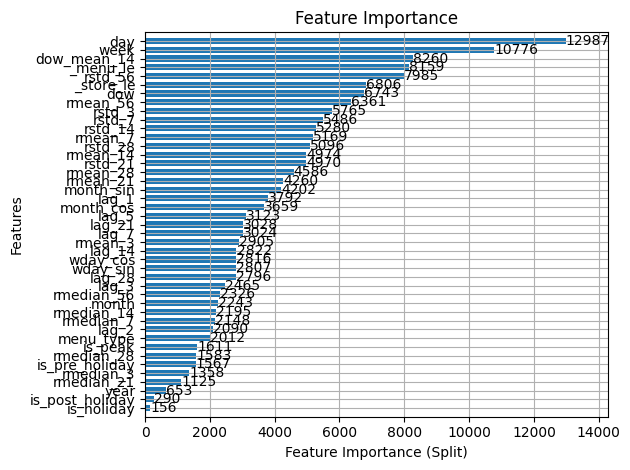

In [29]:
import matplotlib.pyplot as plt

# 폰트가 깨질 경우 대비 (특히 한글 피처명이 있다면)
# 터미널에서 pip install koreanize-matplotlib 설치 필요
try:
    import koreanize_matplotlib
    print("koreanize_matplotlib 적용 완료")
except ImportError:
    print("koreanize_matplotlib가 설치되지 않았습니다. 한글이 깨질 수 있습니다.")

# --------------------------------------------------------------------
# 이 코드를 model = lgb.train(...) 바로 다음에 추가하세요.
# --------------------------------------------------------------------

print("\n피처 중요도를 시각화합니다...")

# 그래프 크기 설정
plt.figure(figsize=(30,30))

# LightGBM 내장 함수를 이용한 피처 중요도 시각화
# top 30개 피처만 표시
lgb.plot_importance(model, height=0.7,
                    title='Feature Importance', xlabel='Feature Importance (Split)', ylabel='Features')

plt.tight_layout() # 그래프 레이아웃 최적화
plt.show() # 그래프 출력